In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import accuracy_score,classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

/home/wwengm/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


,Unnamed: 0,Adjusted_BoxOffice,BoxOffice,NLP_Score,Runtime,Year,imdbRating,imdbVotes,Internet_Movie_Database,Rotten_Tomatoes,...,Thriller,War,Western,Country_count,budget,Adjusted_Budgets,Director_Score,Writer_Score,Actor_Score,Adjusted_BoxOffice_Cat
count,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9.322000e+03,9322.000000,9322.000000,...,9322.000000,9322.000000,9322.000000,9322.000000,3.428000e+03,3428.000000,9322.000000,9322.000000,9322.000000,9322.000000
mean,5777.557069,28.648639,21.948306,9.158985,104.624973,2005.691697,6.378696,5.093996e+04,6.378696,5.706821,...,0.204784,0.030573,0.011049,1.535078,3.833468e+07,48.302463,0.185111,0.058521,1.170707,3.429522
std,3272.476375,64.164851,51.199261,5.261931,17.940863,7.626457,1.004886,1.191995e+05,1.004886,2.639098,...,0.403566,0.172167,0.104538,0.974243,4.505118e+07,53.827954,0.222282,0.077962,1.032925,1.641061
min,0.000000,0.000082,0.000074,1.046110,53.000000,1990.000000,1.100000,6.000000e+00,1.100000,0.000000,...,0.000000,0.000000,0.000000,1.000000,6.000000e+03,0.009063,0.003643,0.001292,0.049414,0.000000
25%,2833.250000,0.082429,0.066174,4.624634,92.000000,2000.000000,5.800000,2.052000e+03,5.800000,3.700000,...,0.000000,0.000000,0.000000,1.000000,9.200000e+06,11.353044,0.040028,0.020553,0.281805,2.000000
50%,5973.500000,1.657188,1.250904,8.212019,101.000000,2007.000000,6.500000,9.069500e+03,6.500000,5.940134,...,0.000000,0.000000,0.000000,1.000000,2.400000e+07,29.612011,0.102769,0.025294,0.879665,3.000000
75%,8675.750000,29.015950,21.010307,12.778660,113.000000,2012.000000,7.100000,4.437925e+04,7.100000,8.000000,...,0.000000,0.000000,0.000000,2.000000,5.000000e+07,66.110107,0.244908,0.067922,1.781845,5.000000
max,11115.000000,1039.048028,936.658640,28.108077,197.000000,2018.000000,9.300000,2.018482e+06,9.300000,10.000000,...,1.000000,1.000000,1.000000,16.000000,4.250000e+08,501.035781,1.864951,0.903116,6.112091,7.000000


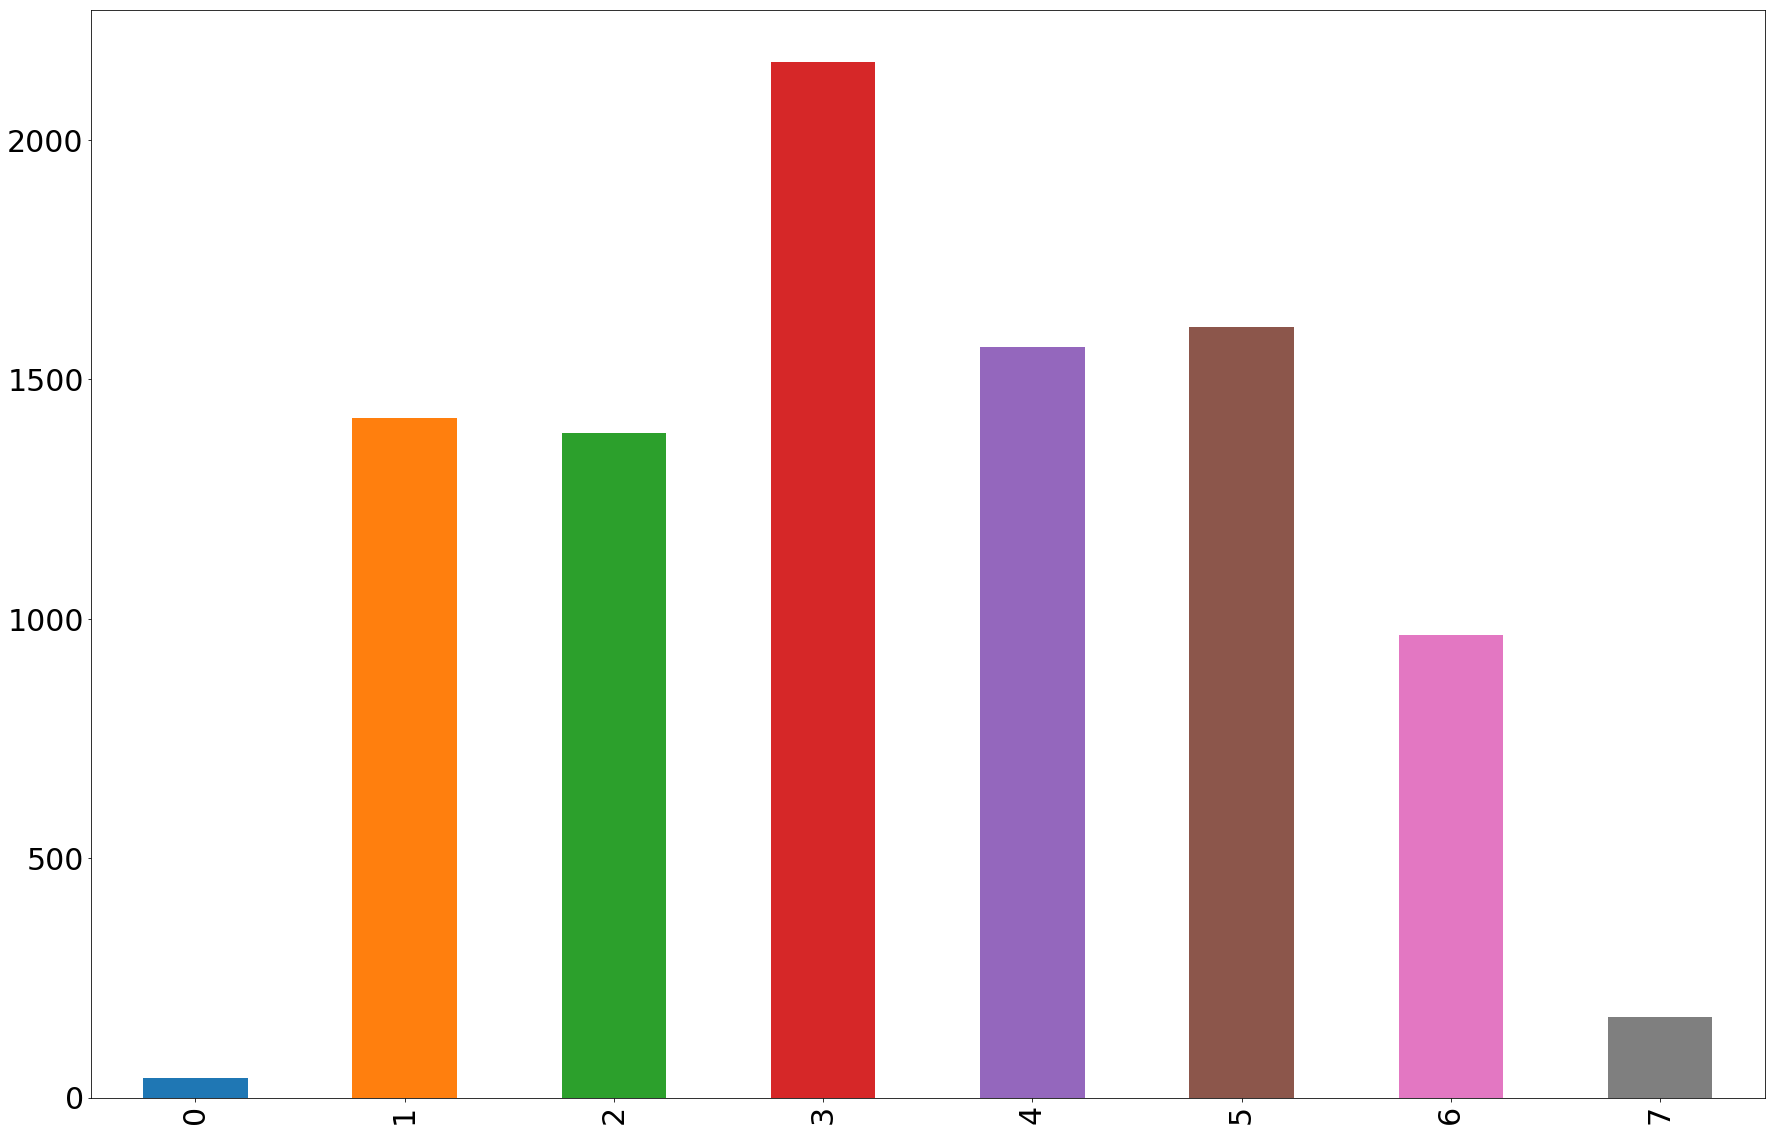

In [27]:
data = pd.read_csv('./data/data_combined_budget.csv')
data = data[(data.Runtime >= 50) & (data.Runtime <= 200) & (data.Year >= 1990)]

# transfer to category
log_boxoffice = np.log(data['Adjusted_BoxOffice'])
cat_raw = pd.cut(log_boxoffice, [-10,-6,-4,-2,0,2,4,6,10])
all_cats = cat_raw.unique()
cat_encoder = dict([(i,x) for x,i in enumerate(all_cats)])
data['Adjusted_BoxOffice_Cat'] = cat_raw.replace(cat_encoder)
data['Adjusted_BoxOffice_Cat'].value_counts().sort_index().plot(kind='bar',figsize = (30,20),fontsize = 30)
data.describe()

In [3]:
# baseline

def lr_classfier(X_train, X_test, y_train, y_test,penalty = 'l2',C = 1.0):
    lr_clf = LogisticRegression(penalty = penalty, C = C)
    scores = cross_val_score(lr_clf, X_train, y_train, cv=5)

    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(X_test)
    tst_acc = accuracy_score(y_test, y_pred) * 100
    cv_acc = np.mean(scores) * 100
    return (tst_acc,cv_acc)


data_model1 = data[['Adjusted_BoxOffice_Cat', 'Runtime',
        'Action','Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Short', 'Sport',
       'Thriller', 'War', 'Western', 'Country_count']]

X = data_model1.drop('Adjusted_BoxOffice_Cat',axis = 1)
y = data_model1['Adjusted_BoxOffice_Cat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 1)


for penalty in ['l1','l2']:
    for C in [0.01, 1.0,10.0,10**3,10**6]:
        tst_acc,cv_acc = lr_classfier(X_train, X_test, y_train, y_test,penalty,C)
        print('LR Baseline(P=%s,C=%s): CV Accuracy: %0.2f | Testing Accuracy: %0.2f' % (penalty,str(C),cv_acc,tst_acc))

# upper-bound
data_model2 = data[['Adjusted_BoxOffice_Cat', 'Runtime','Year', 'imdbRating', 'imdbVotes',
       'Internet_Movie_Database', 'Rotten_Tomatoes', 'Metacritic',
       'Action','Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Short', 'Sport',
       'Thriller', 'War', 'Western', 'Country_count']]

X = data_model2.drop('Adjusted_BoxOffice_Cat',axis = 1)
y = data_model2['Adjusted_BoxOffice_Cat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 1)

for penalty in ['l1','l2']:
    for C in [0.01, 1.0,10.0,10**3,10**6]:
        tst_acc,cv_acc = lr_classfier(X_train, X_test, y_train, y_test,penalty,C)
        print('LR Upper_bound(P=%s,C=%s): CV Accuracy: %0.2f | Testing Accuracy: %0.2f' % (penalty,str(C),cv_acc,tst_acc))

LR Baseline(P=l1,C=0.01): CV Accuracy: 24.51 | Testing Accuracy: 26.14
LR Baseline(P=l1,C=1.0): CV Accuracy: 31.59 | Testing Accuracy: 31.86
LR Baseline(P=l1,C=10.0): CV Accuracy: 31.48 | Testing Accuracy: 31.43
LR Baseline(P=l1,C=1000): CV Accuracy: 31.46 | Testing Accuracy: 31.57
LR Baseline(P=l1,C=1000000): CV Accuracy: 31.39 | Testing Accuracy: 31.57
LR Baseline(P=l2,C=0.01): CV Accuracy: 29.15 | Testing Accuracy: 30.53
LR Baseline(P=l2,C=1.0): CV Accuracy: 31.66 | Testing Accuracy: 31.64
LR Baseline(P=l2,C=10.0): CV Accuracy: 31.48 | Testing Accuracy: 31.78
LR Baseline(P=l2,C=1000): CV Accuracy: 31.40 | Testing Accuracy: 31.75
LR Baseline(P=l2,C=1000000): CV Accuracy: 31.42 | Testing Accuracy: 31.75
LR Upper_bound(P=l1,C=0.01): CV Accuracy: 39.40 | Testing Accuracy: 41.22
LR Upper_bound(P=l1,C=1.0): CV Accuracy: 40.95 | Testing Accuracy: 42.26
LR Upper_bound(P=l1,C=10.0): CV Accuracy: 41.04 | Testing Accuracy: 42.65
LR Upper_bound(P=l1,C=1000): CV Accuracy: 41.20 | Testing Accurac

In [4]:
# data used in all models, unless otherwise defined.
data_cmn = data[['Adjusted_BoxOffice_Cat', 'Runtime',
        'Action','Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Short', 'Sport',
       'Thriller', 'War', 'Western', 'Country_count','Director_Score','Writer_Score','Actor_Score']]


X = data_cmn.drop('Adjusted_BoxOffice_Cat',axis = 1)
y = data_cmn['Adjusted_BoxOffice_Cat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 1)

In [5]:
# LR
def lr_classfier(X_train, X_test, y_train, y_test,penalty = 'l2',C = 1.0):
    lr_clf = LogisticRegression(penalty = penalty, C = C)
    scores = cross_val_score(lr_clf, X_train, y_train, cv=5)

    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(X_test)
    tst_acc = accuracy_score(y_test, y_pred) * 100
    cv_acc = np.mean(scores) * 100
    return (tst_acc,cv_acc)

for penalty in ['l1','l2']:
    for C in [0.01, 1.0,10.0,10**3,10**6]:
        tst_acc,cv_acc = lr_classfier(X_train, X_test, y_train, y_test,penalty,C)
        print('LR(P=%s,C=%s): CV Accuracy: %0.2f | Testing Accuracy: %0.2f' % (penalty,str(C),cv_acc,tst_acc))

LR(P=l1,C=0.01): CV Accuracy: 31.00 | Testing Accuracy: 32.64
LR(P=l1,C=1.0): CV Accuracy: 36.33 | Testing Accuracy: 36.79
LR(P=l1,C=10.0): CV Accuracy: 36.61 | Testing Accuracy: 36.54
LR(P=l1,C=1000): CV Accuracy: 36.63 | Testing Accuracy: 36.50
LR(P=l1,C=1000000): CV Accuracy: 36.58 | Testing Accuracy: 36.50
LR(P=l2,C=0.01): CV Accuracy: 34.30 | Testing Accuracy: 36.86
LR(P=l2,C=1.0): CV Accuracy: 36.43 | Testing Accuracy: 36.72
LR(P=l2,C=10.0): CV Accuracy: 36.50 | Testing Accuracy: 36.65
LR(P=l2,C=1000): CV Accuracy: 36.43 | Testing Accuracy: 36.40
LR(P=l2,C=1000000): CV Accuracy: 36.50 | Testing Accuracy: 36.47


In [6]:
# SVM
def svm_classfier(X_train, X_test, y_train, y_test,kernel):
    svm_clf = svm.SVC(decision_function_shape='ovo',kernel=kernel)
    scores = cross_val_score(svm_clf, X_train, y_train, cv=5)

    svm_clf.fit(X_train, y_train)
    y_pred = svm_clf.predict(X_test)
    tst_acc = accuracy_score(y_test, y_pred) * 100
    cv_acc = np.mean(scores) * 100
    return (tst_acc,cv_acc)

for kernel in ['linear', 'rbf', 'sigmoid']:
    tst_acc,cv_acc = svm_classfier(X_train, X_test, y_train, y_test,kernel)
    print('SVM(Kernel = %s): CV Accuracy: %0.2f | Testing Accuracy: %0.2f' % (kernel,cv_acc,tst_acc))

SVM(Kernel = linear): CV Accuracy: 36.89 | Testing Accuracy: 37.18
SVM(Kernel = rbf): CV Accuracy: 35.65 | Testing Accuracy: 36.43
SVM(Kernel = sigmoid): CV Accuracy: 23.03 | Testing Accuracy: 23.60


In [7]:
#kNN
def knn_classifier(X_train, X_test, y_train, y_test, n_neighbors):
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
    scores = cross_val_score(neigh, X_train, y_train, cv=5)

    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    tst_acc = accuracy_score(y_test, y_pred) * 100
    cv_acc = np.mean(scores) * 100
    return (tst_acc,cv_acc)

for n_neighbors in range(20,201,20):
    tst_acc,cv_acc = knn_classifier(X_train, X_test, y_train, y_test, n_neighbors)
    print('KNN(K = %s): CV Accuracy: %0.2f | Testing Accuracy: %0.2f' % (str(n_neighbors)
                                                                         ,cv_acc,tst_acc))

KNN(K = 20): CV Accuracy: 30.90 | Testing Accuracy: 32.14
KNN(K = 40): CV Accuracy: 31.69 | Testing Accuracy: 31.03
KNN(K = 60): CV Accuracy: 31.11 | Testing Accuracy: 31.75
KNN(K = 80): CV Accuracy: 30.93 | Testing Accuracy: 32.03
KNN(K = 100): CV Accuracy: 30.88 | Testing Accuracy: 31.68
KNN(K = 120): CV Accuracy: 29.76 | Testing Accuracy: 30.85
KNN(K = 140): CV Accuracy: 29.59 | Testing Accuracy: 30.46
KNN(K = 160): CV Accuracy: 29.23 | Testing Accuracy: 30.43
KNN(K = 180): CV Accuracy: 29.11 | Testing Accuracy: 30.00
KNN(K = 200): CV Accuracy: 28.92 | Testing Accuracy: 29.75


In [8]:
#RF
def rf_classifier(X_train, X_test, y_train, y_test, n_estimators,max_depth):
    rf_clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth)
    scores = cross_val_score(rf_clf, X_train, y_train, cv=5)

    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    tst_acc = accuracy_score(y_test, y_pred) * 100
    cv_acc = np.mean(scores) * 100
    return (tst_acc,cv_acc)

results = {}
for n_estimators in range(50,201,50):
    results[n_estimators] = []
    for max_depth in range(1,21,1):
        tst_acc,cv_acc = rf_classifier(X_train, X_test,y_train,y_test,n_estimators,max_depth)
        print('RF(N = %s, depth = %s): CV Accuracy: %0.2f | Testing Accuracy: %0.2f' % (str(n_estimators),str(max_depth)
                                                                         ,cv_acc,tst_acc))
        results[n_estimators].append(cv_acc)

RF(N = 50, depth = 1): CV Accuracy: 28.40 | Testing Accuracy: 29.67
RF(N = 50, depth = 2): CV Accuracy: 32.08 | Testing Accuracy: 32.07
RF(N = 50, depth = 3): CV Accuracy: 33.66 | Testing Accuracy: 34.72
RF(N = 50, depth = 4): CV Accuracy: 35.19 | Testing Accuracy: 35.61
RF(N = 50, depth = 5): CV Accuracy: 36.09 | Testing Accuracy: 36.47
RF(N = 50, depth = 6): CV Accuracy: 37.09 | Testing Accuracy: 37.50
RF(N = 50, depth = 7): CV Accuracy: 37.73 | Testing Accuracy: 39.01
RF(N = 50, depth = 8): CV Accuracy: 38.11 | Testing Accuracy: 38.76
RF(N = 50, depth = 9): CV Accuracy: 38.86 | Testing Accuracy: 39.58
RF(N = 50, depth = 10): CV Accuracy: 38.64 | Testing Accuracy: 40.47
RF(N = 50, depth = 11): CV Accuracy: 38.54 | Testing Accuracy: 39.94
RF(N = 50, depth = 12): CV Accuracy: 38.54 | Testing Accuracy: 41.12
RF(N = 50, depth = 13): CV Accuracy: 37.88 | Testing Accuracy: 39.61
RF(N = 50, depth = 14): CV Accuracy: 38.69 | Testing Accuracy: 39.94
RF(N = 50, depth = 15): CV Accuracy: 38.27 

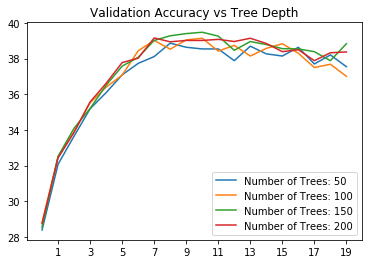

In [9]:
cv_acc_rf = pd.DataFrame(results)
cv_acc_rf.columns = ['Number of Trees: %s' % str(x) for x in cv_acc_rf.columns]
cv_acc_rf.plot(title='Validation Accuracy vs Tree Depth',xticks=range(1,21,2))

In [10]:
def one_hot_encoding(y):
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_y = encoder.transform(y)
    dummy_y = np_utils.to_categorical(encoded_y)
    return (dummy_y)

In [11]:
dummy_y_train = one_hot_encoding(y_train)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

def nn_classifier(X_train, X_test, y_train, y_test, patience):
    model = Sequential()
    model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(len(all_cats), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    callbacks = [EarlyStopping(monitor='val_loss', patience=patience)]
    model.fit(X_train, dummy_y_train, batch_size = 64, epochs = 400, callbacks=callbacks, validation_data=(X_test, one_hot_encoding(y_test)),verbose = 0)


    predictions = model.predict_classes(X_test)
    y_pred = np.argmax(np_utils.to_categorical(predictions), axis = 1)

    train_predictions = model.predict_classes(X_train)
    train_y_pred = np.argmax(np_utils.to_categorical(train_predictions), axis = 1)
    
    tst_acc = accuracy_score(y_test, y_pred) * 100
    tr_acc = accuracy_score(y_train, train_y_pred) * 100
    return (tst_acc,tr_acc,callbacks[0].stopped_epoch)

# for bs in range(20,100,20):
#     for ep in [50,100,150]:
#         tst_acc,cv_acc = nn_classifier(X_train, X_test, y_train, y_test, bs, ep)
#         print('NN(BatchSize = %s, epochs = %s): CV Accuracy: %0.2f | Testing Accuracy: %0.2f' % (str(bs),str(ep)
#                                                                          ,cv_acc,tst_acc))

for patience in range(5,15):
    tst_acc,cv_acc,ep = nn_classifier(X_train, X_test, y_train, y_test, patience)
    print('NN (patience = %s): epoch: %s | CV Accuracy: %0.2f | Testing Accuracy: %0.2f' % (str(patience),str(ep)
                                                                              ,cv_acc,tst_acc))

NN (patience = 5): epoch: 39 | CV Accuracy: 42.38 | Testing Accuracy: 38.04
NN (patience = 6): epoch: 41 | CV Accuracy: 42.24 | Testing Accuracy: 38.40
NN (patience = 7): epoch: 40 | CV Accuracy: 41.78 | Testing Accuracy: 38.33
NN (patience = 8): epoch: 46 | CV Accuracy: 42.04 | Testing Accuracy: 39.36
NN (patience = 9): epoch: 48 | CV Accuracy: 42.31 | Testing Accuracy: 38.36
NN (patience = 10): epoch: 39 | CV Accuracy: 41.90 | Testing Accuracy: 38.18
NN (patience = 11): epoch: 52 | CV Accuracy: 42.42 | Testing Accuracy: 38.29
NN (patience = 12): epoch: 50 | CV Accuracy: 42.68 | Testing Accuracy: 37.47
NN (patience = 13): epoch: 51 | CV Accuracy: 42.65 | Testing Accuracy: 37.86
NN (patience = 14): epoch: 69 | CV Accuracy: 42.30 | Testing Accuracy: 37.75


/home/wwengm/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.0, 0.0, 0.0]
[0.63, 0.47, 0.54]
[0.33, 0.13, 0.19]
[0.41, 0.67, 0.51]
[0.33, 0.24, 0.28]
[0.34, 0.54, 0.42]
[0.37, 0.18, 0.24]
[0.0, 0.0, 0.0]
plotMat: [[0.0, 0.0, 0.0], [0.63, 0.47, 0.54], [0.33, 0.13, 0.19], [0.41, 0.67, 0.51], [0.33, 0.24, 0.28], [0.34, 0.54, 0.42], [0.37, 0.18, 0.24], [0.0, 0.0, 0.0]]
support: [15, 433, 406, 660, 485, 480, 269, 49]


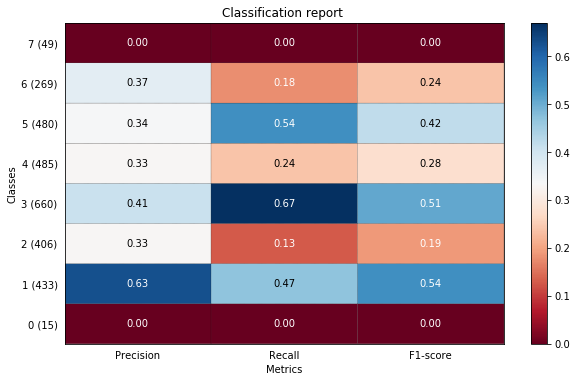

In [12]:
# ref: https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

rf_clf = RandomForestClassifier(n_estimators=100,max_depth=11)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
rp = classification_report(y_test, y_pred)
plot_classification_report(rp)

/home/wwengm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/wwengm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/wwengm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

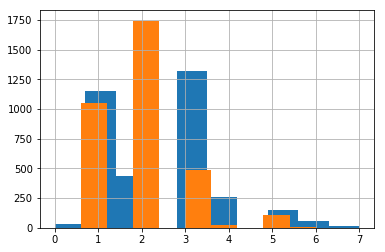

In [13]:
#budget

data_budget = data[data.Adjusted_Budgets.notna()]
data_budget['log_Adjusted_Budgets'] = np.log(data_budget['Adjusted_Budgets'] )


log_boxoffice = np.log(data_budget['Adjusted_BoxOffice'])
cat_raw = pd.cut(log_boxoffice, [-10,-6,-4,-2,0,2,4,6,10])
all_cats = cat_raw.unique()
cat_encoder = dict([(i,x) for x,i in enumerate(all_cats)])
data_budget['Adjusted_BoxOffice_Cat'] = cat_raw.replace(cat_encoder)
data_budget['Adjusted_BoxOffice_Cat'].hist()

log_Adjusted_Budgets = np.log(data_budget['Adjusted_Budgets'])
cat_raw = pd.cut(log_Adjusted_Budgets, [-10,-6,-4,-2,0,2,4,6,10])
all_cats = cat_raw.unique()
cat_encoder = dict([(i,x) for x,i in enumerate(all_cats)])
data_budget['Adjusted_Budgets_Cat'] = cat_raw.replace(cat_encoder)
data_budget['Adjusted_Budgets_Cat'].hist()

In [14]:
import statsmodels.api as sm

data_budget['log_Adjusted_Budgets'] = np.log(data_budget['Adjusted_Budgets'] )
data_budget['log_Adjusted_BoxOffice'] = np.log(data_budget['Adjusted_BoxOffice'] )

#Baseline Model: A simple Regression

data_model8 = data_budget[['log_Adjusted_BoxOffice', 'Runtime',
        'Action','Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Short', 'Sport',
       'Thriller', 'War', 'Western', 'Country_count']]

X = data_model8.drop('log_Adjusted_BoxOffice',axis = 1)
y = data_model8['log_Adjusted_BoxOffice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 1)


lr_model1 = sm.OLS(y_train, sm.add_constant(X_train))
lr_est1 = lr_model1.fit()
print(lr_est1.summary())

# Out of Sample
pred = lr_est1.predict(sm.add_constant(X_test))
oosr = 1 - sum([x*x for x in (pred-y_test)])/sum([x*x for x in (sum(y_train)/len(y_train)-y_test)])
print('Out of Sample R2 is : %s' %round(oosr,3))


data_model9 = data_budget[['log_Adjusted_BoxOffice', 'Runtime',
        'Action','Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Short', 'Sport',
       'Thriller', 'War', 'Western', 'Country_count','log_Adjusted_Budgets']]

X = data_model9.drop('log_Adjusted_BoxOffice',axis = 1)
y = data_model9['log_Adjusted_BoxOffice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 1)


lr_model1 = sm.OLS(y_train, sm.add_constant(X_train))
lr_est1 = lr_model1.fit()
print(lr_est1.summary())

# Out of Sample
pred = lr_est1.predict(sm.add_constant(X_test))
oosr = 1 - sum([x*x for x in (pred-y_test)])/sum([x*x for x in (sum(y_train)/len(y_train)-y_test)])
print('Out of Sample R2 is : %s' %round(oosr,3))

/home/wwengm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/wwengm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


                              OLS Regression Results                              
Dep. Variable:     log_Adjusted_BoxOffice   R-squared:                       0.255
Model:                                OLS   Adj. R-squared:                  0.248
Method:                     Least Squares   F-statistic:                     33.91
Date:                    Fri, 07 Dec 2018   Prob (F-statistic):          5.84e-133
Time:                            20:50:36   Log-Likelihood:                -5223.6
No. Observations:                    2399   AIC:                         1.050e+04
Df Residuals:                        2374   BIC:                         1.064e+04
Df Model:                              24                                         
Covariance Type:                nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const 